In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from plotly import tools
import plotly.graph_objs as go
import gc
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

In [137]:
df = pd.read_csv("bitcoin.csv")

In [138]:
df = df[["Timestamp", "Close"]]
df

,Timestamp,Close
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN
...,...,...
4857372,1617148560,58686.00
4857373,1617148620,58685.81
4857374,1617148680,58723.84
4857375,1617148740,58760.59


Replace null values using forward fill, which will propagate last valid observation

In [139]:
df['Close'].fillna(method='ffill', inplace=True)
df

,Timestamp,Close
0,1325317920,4.39
1,1325317980,4.39
2,1325318040,4.39
3,1325318100,4.39
4,1325318160,4.39
...,...,...
4857372,1617148560,58686.00
4857373,1617148620,58685.81
4857374,1617148680,58723.84
4857375,1617148740,58760.59


Create new value with Timestamp column converted to date

In [140]:
df["Date"] = pd.to_datetime(df["Timestamp"],unit="s").dt.date
df

,Timestamp,Close,Date
0,1325317920,4.39,2011-12-31
1,1325317980,4.39,2011-12-31
2,1325318040,4.39,2011-12-31
3,1325318100,4.39,2011-12-31
4,1325318160,4.39,2011-12-31
...,...,...,...
4857372,1617148560,58686.00,2021-03-30
4857373,1617148620,58685.81,2021-03-30
4857374,1617148680,58723.84,2021-03-30
4857375,1617148740,58760.59,2021-03-30


Group days together and create price column with mean price from the days

In [141]:
group = df.groupby("Date")
data = group["Close"].mean()
data.shape

(3376,)

Check for null values

In [142]:
data.isnull().sum()

0

In [143]:
data

Date
2011-12-31        4.472624
2012-01-01        4.680778
2012-01-02        5.000000
2012-01-03        5.145917
2012-01-04        5.228729
                  ...     
2021-03-27    55194.452319
2021-03-28    55835.612028
2021-03-29    56911.995660
2021-03-30    58348.516944
2021-03-31    58778.180000
Name: Close, Length: 3376, dtype: float64

Leave last 30 days for test and take the rest for training

In [144]:
timestep=30
price_train=data.iloc[:len(data)-timestep]
price_test=data.iloc[len(price_train):]

Scale the values to be in range 0-1 to avoid bias towards huge prices.

In [145]:
price_train=np.array(price_train)
price_train=price_train.reshape(price_train.shape[0],1)
scaler=MinMaxScaler(feature_range=(0,1))
price_train_scaled=scaler.fit_transform(price_train)

Create train dataset, we take pairs of 50 days as X value and 51th day for y value

In [146]:
x_train=[]
y_train=[]

for i in range(timestep, price_train_scaled.shape[0]):
    x_train.append(price_train_scaled[i-timestep:i, 0])
    y_train.append(price_train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

Define LSTM model and run training for 50 epochs

In [ ]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,
          y_train,
          epochs=50,
          batch_size=32,
          verbose=1)

Scale the price data reserved for testing

In [148]:
price_test_scaled=data[len(data)-len(price_test)-timestep:]
price_test_scaled=price_test_scaled.values.reshape(-1,1)
price_test_scaled=scaler.transform(price_test_scaled)

Create test data

In [149]:
x_test=[]
for i in range(timestep, price_test_scaled.shape[0]):
    x_test.append(price_test_scaled[i-timestep:i,0])

x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

Create predictions on test data with LSTM model and inverse scale them back to original values.

In [150]:
pred=model.predict(x_test)
pred=scaler.inverse_transform(pred)

In [151]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

Visualize the predictions with the original graph

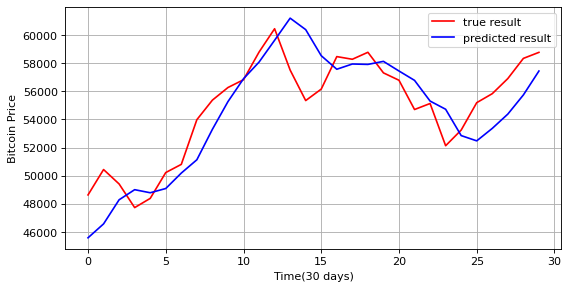

In [152]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(pred,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(30 days)")
plt.ylabel("Bitcoin Price")
plt.grid(True)
plt.show()

The predicted values are not far off from the original, but for a starting point I'd say its fine.